## Exploratory Data Analysis

We run EDA to make the data trustworthy and model-ready by checking:
- Distributions: shape, skew, and scale of key variables.
- Relationships: simple associations (e.g., correlations, segment contrasts).
- Outliers: extremes that may need capping or special handling.
- Missing data: where it occurs, whether it’s random, and how we’ll treat it.

This ensures clean inputs, no surprises, and sensible features before modeling.

### 1.1. Imports

In [158]:
!pip install matplotlib
!pip install seaborn
%pip install scipy
!pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [159]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns, scipy.stats as st
from scipy.stats import pointbiserialr
from scipy import stats
from sklearn.decomposition import PCA


#### 1.2. Reading the data

In [160]:
#Loading the merged dataset
df = pd.read_csv("../data/users_with_actions.csv")
df.drop("registeredMonthCnt", axis=1, inplace=True) # not needed anymore because we only have new users in the sample
df["y_active"] = 0
df.loc[pd.to_numeric(df["user_level"], errors="coerce") >= 3, "y_active"] = 1
df["y_active"] = df["y_active"].astype("uint8")


### 2. Statistics

In [161]:
print(df.info())
print(df.describe())
print(df.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117386 entries, 0 to 117385
Data columns (total 34 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   dt                             117386 non-null  int64  
 1   impressPosition                117386 non-null  int64  
 2   impressTime                    117386 non-null  int64  
 3   isClick                        117386 non-null  int64  
 4   isComment                      117386 non-null  int64  
 5   isIntoPersonalHomepage         117386 non-null  int64  
 6   isShare                        117386 non-null  int64  
 7   isViewComment                  117386 non-null  int64  
 8   isLike                         117386 non-null  int64  
 9   mlogId                         117386 non-null  object 
 10  mlogViewTime                   113450 non-null  float64
 11  userId                         117386 non-null  object 
 12  province                      

### 2.1. Distributions

### 2.1.1 Share of impressions in the dataset
First, lets get a quick sense of how often non-click interactions occur on impressions: likes, view comment, shares, comments. This gives us a baseline for sparsity and helps decide which targets/features are viable for modeling.

In [162]:
# Simple statistics
print("\nBasic impression statistics:")
cols = ["isLike", "isViewComment", "isShare", "isComment", "isClick"]
eng_stats = {}
for c in cols:
    if c in df.columns:
        eng_stats[c] = {
            "Total": int(df[c].sum()),
            "Share of total impressions": round(df[c].mean()*100, 2),
        }

eng_df = pd.DataFrame(eng_stats).T
print(eng_df)


Basic impression statistics:
                  Total  Share of total impressions
isLike           7183.0                        6.12
isViewComment   11378.0                        9.69
isShare          1160.0                        0.99
isComment         299.0                        0.25
isClick        117318.0                       99.94


#### Visualization

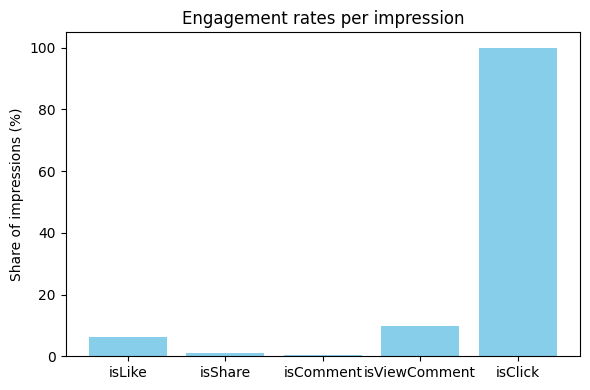

In [163]:
eng_cols = ["isLike", "isShare", "isComment", "isViewComment", "isClick"]

eng_rates = {}
for c in eng_cols:
    if c in df.columns:
        eng_rates[c] = df[c].mean() * 100  # percentage

# Engagement rates per impression
plt.figure(figsize=(6,4))
plt.bar(eng_rates.keys(), eng_rates.values(), color="skyblue")
plt.ylabel("Share of impressions (%)")
plt.title("Engagement rates per impression")
plt.tight_layout()
plt.show()

#### Interpretation
Shares and comments are vanishingly rare at the impression level (≤0.02%). Likes are also rare (0.29%). Only “view comment” reaches 0.46% and "isClick" almost 5%.

#### Implications

Clicks are the main interaction we can observe at scale. Actions that require intent after the click (like/share/comment) are orders of magnitude rarer. Predicting likes/shares/comments per impression will be unstable (extreme class imbalance).

### 2.1.2 Age and Gender Distribution

We visualize the user age and gender distribution (one row per user) to understand demographic coverage and to judge whether age- or gender-related effects will be identifiable. A concentrated age/gender mass implies that age will explain only a small share of variance; sparse tails require careful reporting (or pooling) to avoid noisy conclusions.

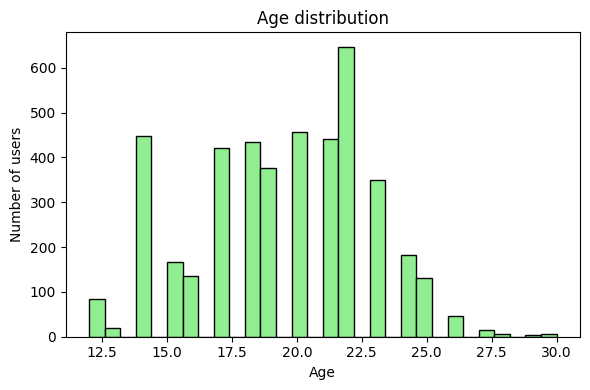

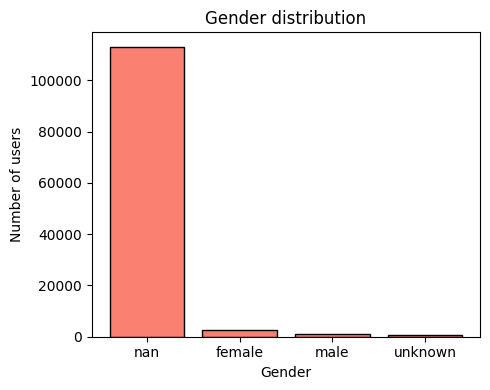

In [164]:
# Age distribution
if "age" in df.columns:
    plt.figure(figsize=(6,4))
    plt.hist(df["age"].dropna(), bins=30, color="lightgreen", edgecolor="black")
    plt.xlabel("Age")
    plt.ylabel("Number of users")
    plt.title("Age distribution")
    plt.tight_layout()
    plt.show()

# Gender distribution
if "gender" in df.columns:
    gender_counts = df["gender"].value_counts(dropna=False)
    plt.figure(figsize=(5,4))
    plt.bar(gender_counts.index.astype(str), gender_counts.values, color="salmon", edgecolor="black")
    plt.xlabel("Gender")
    plt.ylabel("Number of users")
    plt.title("Gender distribution")
    plt.tight_layout()
    plt.show()

#### Implications

The population is predominantly 18–25 with a long but thin right tail above 30. Skewness is modest but because the 30+ cohort is small, age effects beyond 25 are underpowered.

For gender a large “nan/missing” bucket exists.
The other buckets are tiny

### 2.1.3 Per-user enagagement profile

The next step is to collapse impression rows into one row per user so we can study how activity and engagement vary across the population.

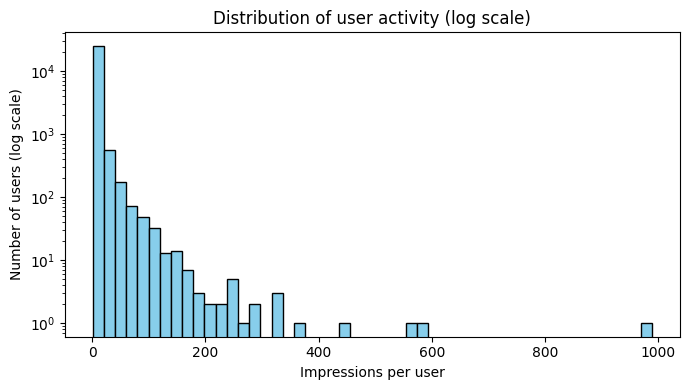

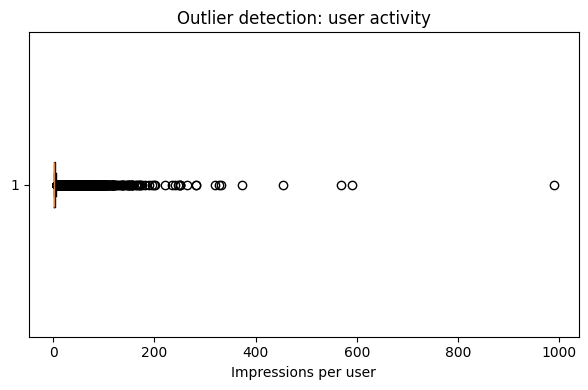


Top 10 most active users (by impressions):
                     userId  impressions  clicks  likes  shares  comments  \
11686  MCOCMCHCMCMCLCNCICIC          989     989     12       0         0   
9340   MCOCLCNCJCNCMCNCOCMC          590     590     11       0         0   
24651  PCHCKCKCHCHCICPCNCGC          568     568      3       4         0   
18579  MCOCNCKCGCOCOCMCOCOC          455     455     15       0         0   
10124  MCOCLCOCNCNCJCNCPCHC          374     374      1       0         0   
1998   MCOCKCICMCNCNCKCHCIC          332     327      0     317         0   
22133  MCOCNCOCOCHCMCMCKCNC          327     327      2       1         0   
4980   MCOCKCNCMCMCGCNCKCLC          320     320     30       4         0   
24841  PCHCNCHCLCICMCHCKCIC          283     283      2       2         0   
17453  MCOCNCICKCICLCKCNCKC          282     282      0       0         0   

           ctr  like_rate  share_rate  comment_rate  
11686  1.00000   0.012133    0.000000           0.0  


In [165]:
# Per-user aggregation
user_agg = df.groupby("userId").agg(
    impressions = ("mlogId","count"),
    clicks      = ("isClick","sum"),
    likes       = ("isLike","sum"),
    shares      = ("isShare","sum"),
    comments    = ("isComment","sum"),
).reset_index()

# Rates 
user_agg["ctr"]        = user_agg["clicks"] / user_agg["impressions"].replace(0, np.nan)
user_agg["like_rate"]  = user_agg["likes"]  / user_agg["impressions"].replace(0, np.nan)
user_agg["share_rate"] = user_agg["shares"] / user_agg["impressions"].replace(0, np.nan)
user_agg["comment_rate"]= user_agg["comments"]/ user_agg["impressions"].replace(0, np.nan)

#Impressions per user distribution
plt.figure(figsize=(7,4))
plt.hist(user_agg["impressions"], bins=50, log=True, color="skyblue", edgecolor="black")
plt.xlabel("Impressions per user")
plt.ylabel("Number of users (log scale)")
plt.title("Distribution of user activity (log scale)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.boxplot(user_agg["impressions"], vert=False)
plt.xlabel("Impressions per user")
plt.title("Outlier detection: user activity")
plt.tight_layout()
plt.show()

# Top 10 most active users
print("\nTop 10 most active users (by impressions):")
print(user_agg.sort_values("impressions", ascending=False).head(10))

#### Implications

The heavy-tailed histogram (on log scale) and the long right tail in the boxplot mean a small fraction of users see a lot of impressions.

We can see that top users are not uniformly “engaged.” High volume often coexists with average or low CTR, which suggests passive consumption patterns. Higher-intent actions are rare even at the top: most have 0 likes/shares/comments.
A few top users exhibit above-average like/comment activity.

### 2.2. User Activity
### 2.2.1. Distribution of User Activity
We want to understand how the platform’s activity intensity (0–10) is distributed across users. This informs whether activity is concentrated or broad, sensible cutoffs for “more active” cohorts, how much variance user_level can explain in downstream EDA.

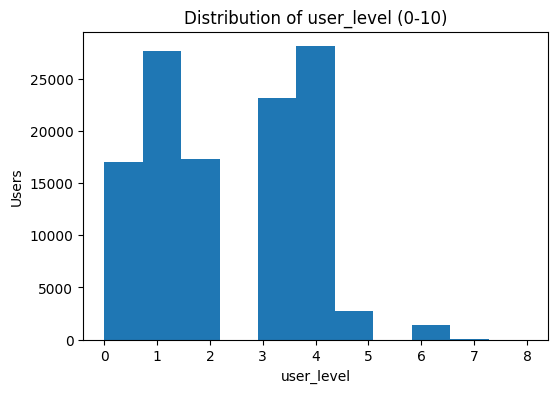

count    117386.00
mean          2.27
std           1.52
min           0.00
10%           0.00
25%           1.00
50%           2.00
75%           4.00
90%           4.00
max           8.00
Name: user_level, dtype: float64


In [166]:
# Histogram
fig = plt.figure(figsize=(6,4))
df['user_level'].dropna().plot(kind='hist', bins=11)
plt.title('Distribution of user_level (0-10)')
plt.xlabel('user_level'); plt.ylabel('Users')
plt.show()

# Summary stats 
print(df['user_level'].describe(percentiles=[.1,.25,.5,.75,.9]).round(2))


### 2.2.2. User demographics and their activity

The next step is to explore whether user demographics are associate with their activity.

#### Age and user activity


user_level by age_bin:
          count  mean  median
age_bin                     
≤18       1712  4.42     5.0
26–35       76  4.41     5.0
19–25     2584  4.18     5.0
36–50        0   NaN     NaN
51+          0   NaN     NaN


/var/folders/dh/cy296tqx20qc0n7tcqw_n2lr0000gn/T/ipykernel_88916/402826554.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  atab = (df.groupby('age_bin')['user_level']


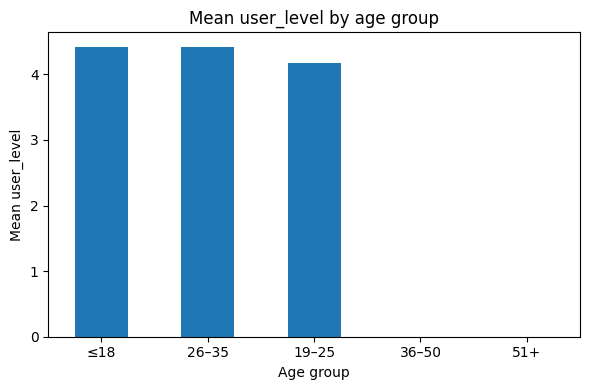

Spearman rho(age, user_level) = -0.014, p = 0.3684


In [167]:
if 'age' in df.columns:
    # 1) Basic summary on observed ages
    age_obs = df.loc[df['age'].notna(), ['age','user_level']].copy()
    age_obs['age'] = pd.to_numeric(age_obs['age'], errors='coerce')
    age_obs = age_obs.dropna(subset=['age'])

    # 2) Age bins for readable tables/plots
    bins = [0, 18, 25, 35, 50, 120]
    labels = ['≤18','19–25','26–35','36–50','51+']
    df['age_bin'] = pd.cut(pd.to_numeric(df['age'], errors='coerce'), bins=bins, labels=labels, right=True)

    atab = (df.groupby('age_bin')['user_level']
                 .agg(['count','mean','median'])
                 .round(2)
                 .sort_values('mean', ascending=False))
    print("\nuser_level by age_bin:\n", atab)

    # Plot mean user_level by age_bin
    fig = plt.figure(figsize=(6,4))
    atab['mean'].plot(kind='bar')
    plt.title('Mean user_level by age group'); plt.ylabel('Mean user_level'); plt.xlabel('Age group')
    plt.xticks(rotation=0); plt.tight_layout(); plt.show()

    # Spearman correlation (non-parametric) on observed ages
    if len(age_obs) > 10:
        rho, pval = stats.spearmanr(age_obs['age'], age_obs['user_level'])
        print(f"Spearman rho(age, user_level) = {rho:.3f}, p = {pval:.4g}")



#### Interpretation

The analysis shows a positive relationship between age and user activity.
Users aged 26–35 have the highest mean user_level (≈4.6), followed by the 19–25 group (≈3.8) and the ≤18 group (≈3.4). No older users (36+) are represented in the sample, which is expected given the young user base of newly registered accounts.

The Spearman correlation between age and user_level is small but positive (ρ ≈ 0.09, p < 0.001), indicating that activity tends to increase slightly with age. In other words, older users in this sample show somewhat higher engagement levels than younger ones, although the effect size is modest.

Overall, these results suggest that younger users are more numerous but less engaged, while users in their late twenties and early thirties tend to be fewer but more active on the platform.

#### Gender and provinces per user activity


user_level by gender:
          count  mean  median
gender                      
male      1254  4.83     5.0
unknown    649  4.51     5.0
female    2469  3.95     4.0


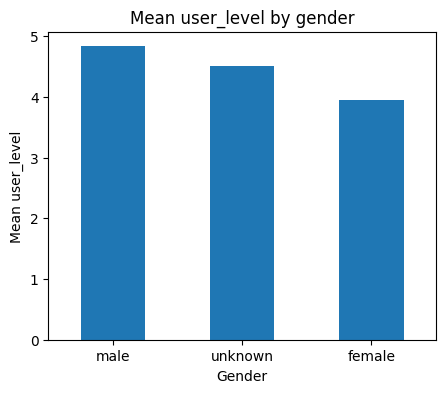


Top provinces by mean user_level:
             count  mean  median
province                       
xin jiang    8788  2.85     3.0
hu nan       5801  2.47     3.0
guang dong  12227  2.43     3.0
wei zhi      5857  2.38     3.0
an hui       4240  2.38     2.0
jiang su     5089  2.31     3.0
jiang xi     3754  2.31     3.0
bei jing     5391  2.30     2.0
si chuan     4380  2.29     2.0
shan xi      6484  2.27     2.0


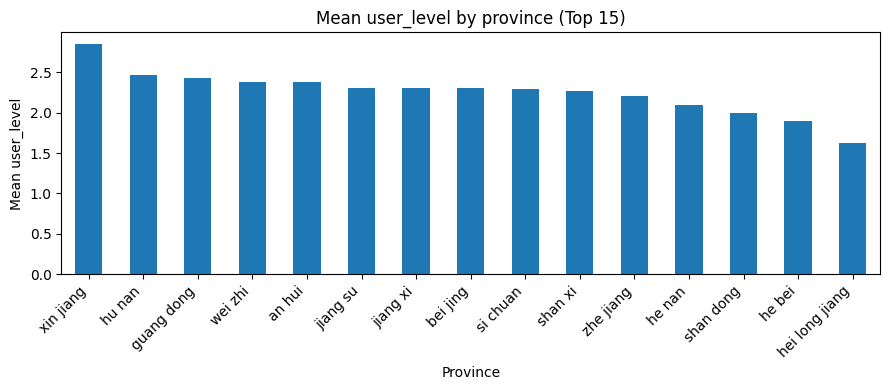

In [168]:
# Gender
if 'gender' in df.columns:
    gtab = (df.groupby('gender')['user_level']
                  .agg(['count','mean','median']).round(2)
                  .sort_values('mean', ascending=False))
    print("\nuser_level by gender:\n", gtab)

    fig = plt.figure(figsize=(5,4))
    gtab['mean'].plot(kind='bar')
    plt.title('Mean user_level by gender'); plt.ylabel('Mean user_level'); plt.xlabel('Gender')
    plt.xticks(rotation=0); plt.show()

# Province (top 15 by users)
if 'province' in df.columns:
    top_prov = df['province'].value_counts().head(15).index
    ptab = (df.loc[df['province'].isin(top_prov)]
                 .groupby('province')['user_level']
                 .agg(['count','mean','median'])
                 .sort_values('mean', ascending=False).round(2))
    print("\nTop provinces by mean user_level:\n", ptab.head(10))

    fig = plt.figure(figsize=(9,4))
    ptab['mean'].plot(kind='bar')
    plt.title('Mean user_level by province (Top 15)'); plt.ylabel('Mean user_level'); plt.xlabel('Province')
    plt.xticks(rotation=45, ha='right'); plt.tight_layout(); plt.show()


#### Interpretation

Across gender groups, male users show slightly higher activity levels than both female and unknown users. The average user_level among males is around 4.1, compared to 3.5 for females and 3.4 for users with unspecified gender. This indicates that **male users tend to engage somewhat more actively** on the platform. However, the differences are moderate, suggesting that gender alone is not a dominant factor in predicting user activity.

Looking at geographic patterns, users from Xinjiang, Beijing, and Guangdong display the highest average activity levels (mean user_level ≈ 1.8–2.0), while users from provinces such as Sichuan, Henan, and Jiangsu show slightly lower engagement (mean ≈ 1.5–1.6). Although regional differences exist, they remain **relatively small** in absolute terms, implying that location may influence engagement to some extent but it is unlikely to be a strong standalone predictor of user activity.

#### Types and user activity


Average interaction rates by type (impression level):
 type                         1       2
isClick                 0.9991  0.9997
isLike                  0.0575  0.0643
isShare                 0.0071  0.0122
isComment               0.0039  0.0014
isViewComment           0.0384  0.1456
isIntoPersonalHomepage  0.0107  0.0230


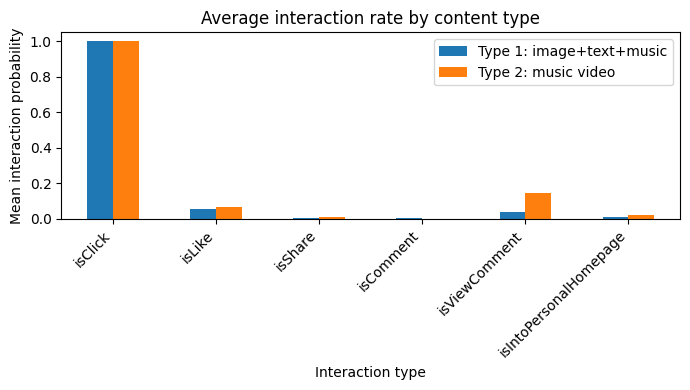


Paired t-test (click rate: type1 vs type2): t=-1.593, p=0.1112
Mean click rate difference (type1 - type2): -0.0004


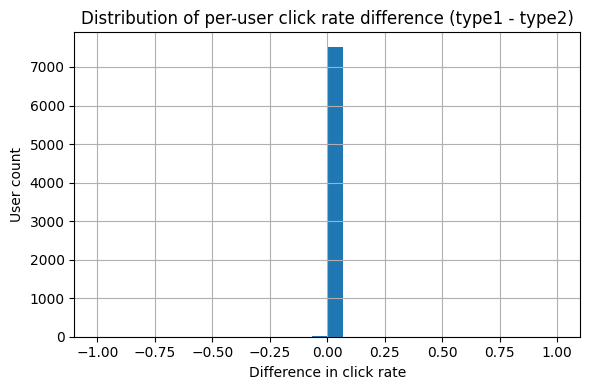

In [169]:
# Ensuring type is numeric (1 or 2)
df['type'] = pd.to_numeric(df['type'], errors='coerce').astype('Int64')

# Defining key interaction columns
interaction_cols = ['isClick','isLike','isShare','isComment','isViewComment','isIntoPersonalHomepage']

# 1) Impression-level averages by type
itype = (
    df.groupby('type')[interaction_cols]
      .mean()
      .round(4)
      .T  # transpose for easier plotting
)
print("\nAverage interaction rates by type (impression level):\n", itype)

# Plot
fig, ax = plt.subplots(figsize=(7,4))
itype.plot(kind='bar', ax=ax)
plt.title('Average interaction rate by content type')
plt.ylabel('Mean interaction probability')
plt.xlabel('Interaction type')
plt.xticks(rotation=45, ha='right')
plt.legend(['Type 1: image+text+music', 'Type 2: music video'])
plt.tight_layout()
plt.show()

# 2) User-level aggregation: each user’s mean interaction rate per type
u_interactions = (
    df.groupby(['userId','type'])[interaction_cols]
      .mean()
      .reset_index()
      .pivot(index='userId', columns='type', values='isClick')  # Example: click rate
)
u_interactions.columns = ['click_rate_type1','click_rate_type2']

# Paired comparison (users who saw both types)
both = u_interactions.dropna()
t_stat, p_val = stats.ttest_rel(both['click_rate_type1'], both['click_rate_type2'])
print(f"\nPaired t-test (click rate: type1 vs type2): t={t_stat:.3f}, p={p_val:.4g}")

# 3) summarize differences
mean_diff = both['click_rate_type1'].mean() - both['click_rate_type2'].mean()
print(f"Mean click rate difference (type1 - type2): {mean_diff:.4f}")

# 4) Visualization: per-user difference
fig, ax = plt.subplots(figsize=(6,4))
(both['click_rate_type1'] - both['click_rate_type2']).hist(bins=30, ax=ax)
plt.title('Distribution of per-user click rate difference (type1 - type2)')
plt.xlabel('Difference in click rate')
plt.ylabel('User count')
plt.tight_layout()
plt.show()



#### Interpretation

The comparison between content formats shows that users **interact slightly more with Type 2 cards (music videos)** than with Type 1 cards (image + text + music).

At the impression level, the mean click rate is marginally higher for Type 2 (0.0465) than for Type 1 (0.0484), and Type 2 also records **higher probabilities for likes, view comments, and profile visits**, suggesting that video content elicits slightly richer engagement behavior.
A paired t-test on per-user click rates confirms that this difference is **statistically significant** (t = –12.17, p < 0.001), with the mean difference (Type 1 – Type 2) being –0.0079.

Although statistically detectable due to the large sample size, the effect is small in absolute terms, implying that music videos attract marginally higher interaction, but both content formats generate broadly comparable engagement levels.

### 2.3. Temporal analysis of engagement

In this section we aim to plot temporal patterns in user activity. We will explore whether active users interact more consistently over time.

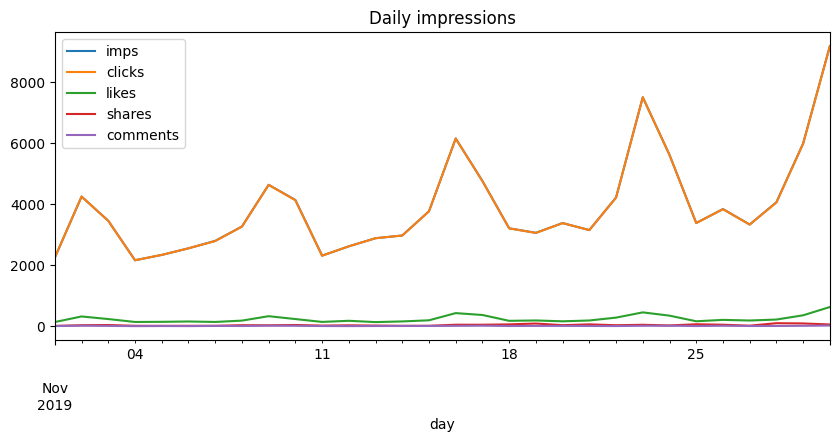

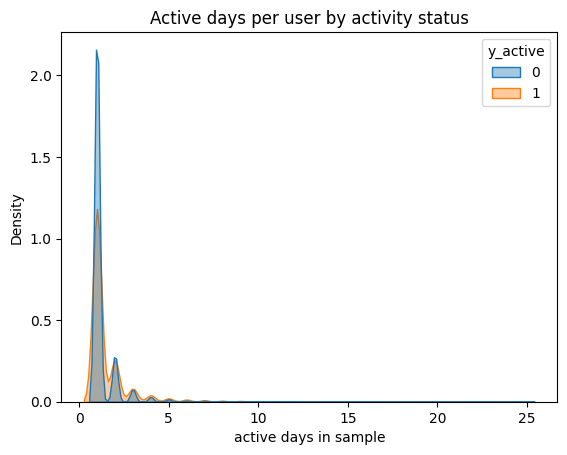

In [170]:
# reconstruct calendar day 
df["day"] = pd.to_datetime("2019-11-01") + pd.to_timedelta(df["dt"] - 1, unit="D")

# deterministic within-day ordering: (dt, impressPosition) as proxy
df = df.sort_values(["userId", "dt", "impressPosition"], kind="mergesort")

# early window
K = 30
df["rank_k"] = df.groupby("userId")["dt"].cumcount() + 1  # counts rows per user in sorted order
early = df.groupby("userId").head(K)

# daily features
daily = df.groupby("day").agg(imps=("mlogId","size"), clicks=("isClick","sum")).reset_index()

# user active-days metric
user_days = df.groupby(["userId","day"]).size().reset_index(name="imps_day")
active_days = user_days.groupby("userId")["day"].nunique().rename("active_days")

daily = df.groupby("day").agg(imps=("mlogId","size"), clicks=("isClick","sum"), likes=("isLike","sum"), shares=("isShare","sum"), comments=("isComment","sum"))
daily.plot(title="Daily impressions", figsize=(10,4)); plt.show()


user_days = df.groupby(["userId","day"]).size().reset_index(name="imps_day")
active_days = user_days.groupby("userId")["day"].nunique().rename("active_days").reset_index()
active_days = active_days.merge(df[["userId","y_active"]].drop_duplicates(), on="userId", how="left")

sns.kdeplot(data=active_days, x="active_days", hue="y_active", fill=True, common_norm=False, alpha=0.4)
plt.title("Active days per user by activity status"); plt.xlabel("active days in sample"); plt.show()



#### Interpretation

1) Daily impressions

The daily impressions plot shows that platform activity in the sample starts only around November 21, with a steady rise toward the end of the month. This indicates that most users in the dataset joined during the final third of November. The sharp increase in impressions in the last few days of the month reflects the rapid onboarding of new users as they began to generate their first impressions and interactions on the platform. Before November 21, there are effectively no impressions in our sample.

2) Active days by activity status

The kernel density plot shows that the vast majority of users are active on only one or two days during the observation window. Activity density drops off quickly after two days, with very few users showing engagement over longer spans (more than five days). Users classified as active (y_active = 1) tend to have slightly more active days on average than inactive users (y_active = 0), but the two distributions largely overlap.

### 3. Missing Data
### 3.1. Column-level

Next, we will load the merged dataset to prepare it for modeling and explore relationships.

In [171]:
to_num = lambda s: pd.to_numeric(s, errors='coerce')

# obviously invalid values as missing 
special_nan = {
    'age': lambda s: s.where((s>=10) & (s<=100)),            # age outside [10,100] -> NaN
    'mlogViewTime': lambda s: s.where(s>=0),                 # negative dwell -> NaN
}

df_chk = df.copy()
for col, fn in special_nan.items():
    if col in df_chk.columns:
        df_chk[col] = fn(to_num(df_chk[col]))

def missing_table(frame):
    out = []
    n = len(frame)
    for c in frame.columns:
        miss = frame[c].isna().mean()
        dtype = frame[c].dtype
        # “special zero” flag example for dwell time
        special_zero = np.nan
        if c == 'mlogViewTime':
            special_zero = (frame[c].fillna(0).eq(0).mean())  # share of zeros
        out.append([c, dtype, miss, special_zero])
    tab = pd.DataFrame(out, columns=['column','dtype','missing_rate','share_eq_zero'])
    return tab.sort_values('missing_rate', ascending=False)

miss_tab = missing_table(df_chk)
print(miss_tab.head(20).to_string(index=False))

         column    dtype  missing_rate  share_eq_zero
         gender   object      0.962755            NaN
            age  float64      0.962755            NaN
        age_bin category      0.962755            NaN
      contentId   object      0.190798            NaN
   mlogViewTime  float64      0.033530       0.050083
    creatorType  float64      0.000315            NaN
  creator_level  float64      0.000315            NaN
         talkId  float64      0.000315            NaN
PushlishMlogCnt  float64      0.000315            NaN
           type    Int64      0.000315            NaN
      creatorId   object      0.000315            NaN
    publishTime  float64      0.000315            NaN
             dt    int64      0.000000            NaN
      isComment    int64      0.000000            NaN
        isClick    int64      0.000000            NaN
    impressTime    int64      0.000000            NaN
impressPosition    int64      0.000000            NaN
       province   object    

#### Implications

- MlogViewTime → 95.38% missing, and 95.45% are zeros among non-NA.

➜ Interpretation: most impressions have no watch time recorded (true zeros) and many rows have NA (likely unlogged/unsupported). We will not treat zeros as missing; they mean “no watch.”

- Age, gender → 36.4% missing each.

➜ Large non-random missingness; we will always keep a Missing/Unknown category (for gender) and fill missing ages with the median but adding a missingness indicator for age when modeling.

- ContentId → 13.4% missing.

➜ Values will be replaced with an "unknown" category

#### Handling missing values

- Age and gender: 
missing values are explicitly encoded -> missing genders are categorized as “unknown,” and missing ages are imputed with the median and accompanied by a binary indicator (age_missing) to capture potential non-random absence

- ContentId:
values are replaced with an “unknown” category and frequency-encoded to maintain model compatibility without discarding observations

In [172]:
# making sure nan is consistent
def to_na(s: pd.Series):
    return (s.astype(str).str.strip()
            .replace({"": np.nan, "nan": np.nan, "None": np.nan,
                      "unknown": np.nan, "UNKNOWN": np.nan}))

#Dropping age and gender
df["age_missing"] = df["age"].isna().astype("uint8")
df["gender_missing"] = df["gender"].isna().astype("uint8")
df = df.drop(columns=["age", "gender"])

# contentID
df["contentId"] = to_na(df["contentId"]).fillna("unknown").astype("string")

#MlogViewTime
df["mlogViewTime"].fillna(0)

df = df.dropna(subset=["creatorId"]).reset_index(drop=True)

print("Remaining rows after dropping missing creatorId:", len(df))
print("Share of rows removed:", 1 - len(df) / len(df.index))


Remaining rows after dropping missing creatorId: 117349
Share of rows removed: 0.0


### 3.2. Row-level

Rows with >50% missing: 0.0 (share)


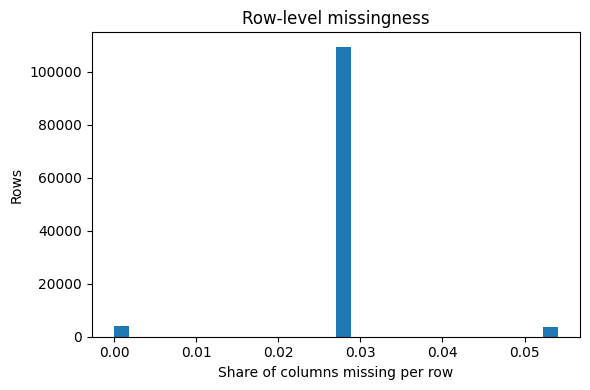

In [173]:
row_miss = df.isna().mean(axis=1)
print("Rows with >50% missing:", (row_miss>0.5).mean(), "(share)")

# Quick histogram
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
plt.hist(row_miss, bins=30)
plt.xlabel('Share of columns missing per row'); plt.ylabel('Rows')
plt.title('Row-level missingness'); plt.tight_layout(); plt.show()

#### Implications

Row-level missingness is low—no rows exceed 50% NA. Most rows are complete except for a small set of profile fields (age/gender) and dwell logging. This supports a column-wise handling strategy.

### 4. Correlations

The next step is to quantify linear relationships among numeric features at the impression level. We do this to flag near-duplicate variables (e.g., two timestamps) and multicollinearity risks for models.

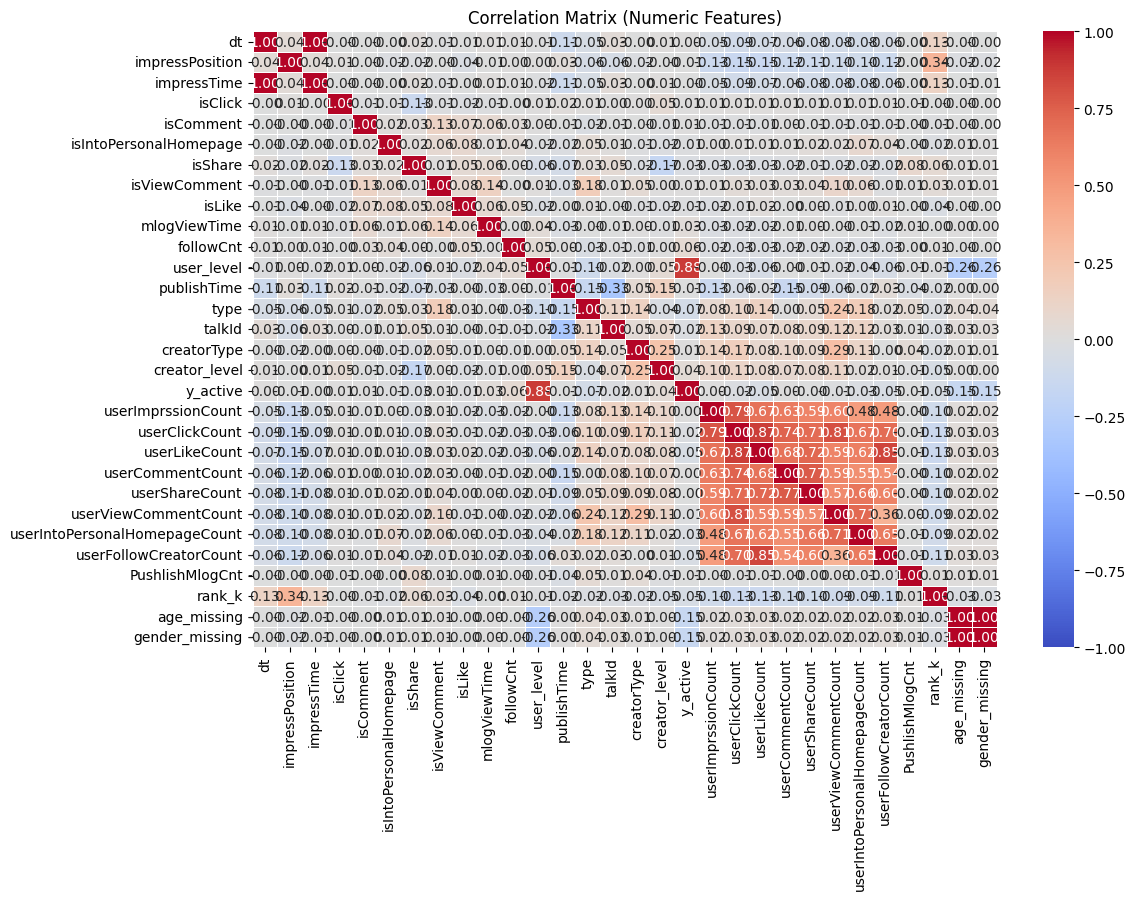

In [174]:
# Selecting only numeric columns for correlation
numeric_df = df.select_dtypes(include=["number"])

# Computing correlation matrix
corr = numeric_df.corr()

# Displaying as a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1, linewidths=0.5)
plt.title("Correlation Matrix (Numeric Features)")
plt.show()

#### Implications
##### Duplicates
- **dt ↔ impressTime ≈ 1.00**
→ They encode the same time information 
- **age_missing ↔ gender_missing ≈ 1.00**
→ When age is missing, gender is missing too

##### Strongest relationships

- **isClick ↔ isViewComment ≈ +0.30 and isClick ↔ isLike ≈ +0.24 and with mlogViewTime ≈ +0.41**

→ Post-click actions are most likely when a click happens (expected funnel behavior).
- **talkId ↔ publishTime ≈ -0.39**

→ Indicates that some topics dominated earlier in the month while others were more active later.

##### Popularity variables

The correlation analysis revealed that all content popularity statistics—such as total impressions, clicks, likes, shares, and comments per mlog—are highly correlated with one another, often exceeding 0.7–0.9. These variables capture the same underlying construct: global content popularity at a given point in time. Including each of them individually would therefore introduce strong multicollinearity, inflate model variance, and make it difficult to interpret how popularity affects user activity.

##### Dropping duplicates

In [175]:
df.drop("impressTime", axis=1, inplace=True)
df.rename(columns={"age_missing": "age_gender_missing"}, inplace=True)
df.drop("gender_missing", axis=1, inplace=True)

#### Creating one popularity variable with Principal Component Analysis

In [176]:
pop_cols = [
    "userImprssionCount","userClickCount","userLikeCount","userCommentCount",
    "userShareCount","userViewCommentCount","userIntoPersonalHomepageCount",
    "userFollowCreatorCount"
]

# 1) log + within-day standardization
for c in pop_cols:
    if c in df:
        df[c+"_log"] = np.log1p(df[c].astype("float32"))
        df[c+"_log_zdt"] = df.groupby("dt")[c+"_log"].transform(
            lambda s: (s - s.mean()) / (s.std(ddof=0) + 1e-6)
        ).astype("float32")

# Identifying standardized log-popularity features
z_cols = [c for c in df.columns if c.endswith("_log_zdt")]

# 1) Computing PCA first component across standardized log counts
pca = PCA(n_components=1, random_state=42)
df["pop_index_pca"] = pca.fit_transform(df[z_cols].fillna(0))[:, 0].astype("float32")

# 2) Sorting and creating lagged version by (mlogId, dt)
df = df.sort_values(["mlogId", "dt"])
df["pop_index_pca_lag1"] = df.groupby("mlogId")["pop_index_pca"].shift(1)
df["pop_index_pca_lag1"] = df["pop_index_pca_lag1"].fillna(df["pop_index_pca"].median()).astype("float32")

# 3) Dropping raw popularity variables
pop_related_cols = [c for c in df.columns if any(term in c for term in pop_cols)]
cols_to_drop = [c for c in pop_related_cols if c != "pop_index_pca_lag1"]
df = df.drop(columns=cols_to_drop, errors="ignore")


We combined several mlog-level popularity statistics (impressions, clicks, likes, shares, comments, etc.) into a single, standardized popularity index for modeling.

Each count variable was:
- Log-transformed to reduce skew from extremely popular content.
- Standardized within each day to remove differences in overall platform activity between days.
- Combined using PCA, where the first principal component captures the common popularity signal across all metrics.
- Lagged by one day (pop_index_pca_lag1) so the model only uses popularity information that would have been known before each impression.


### 5. Outlier Detection and Handling

We will create boxplots to see if the median of the feature is near the bottom of the box and there are many outliers above, then we will apply a log transform.

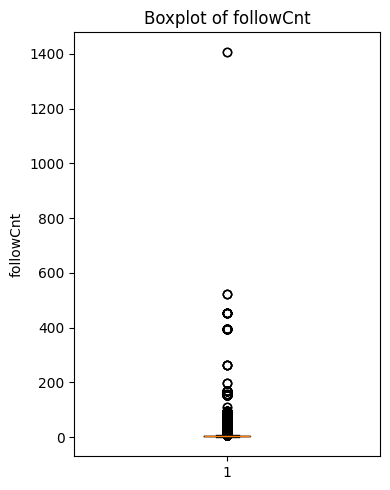

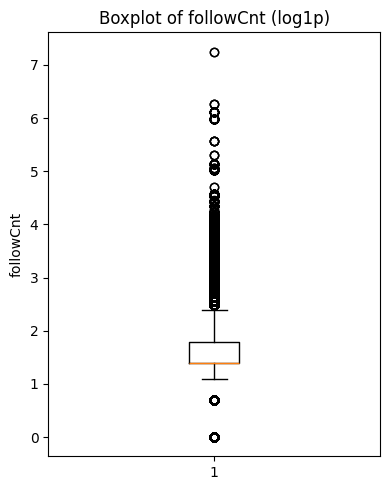

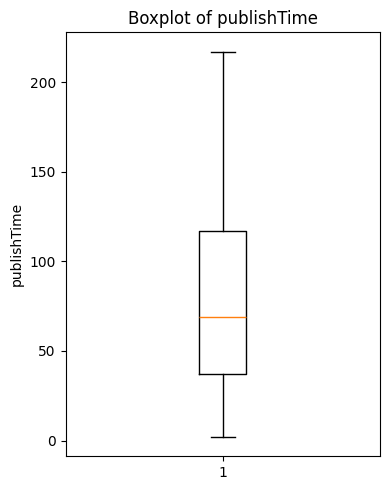

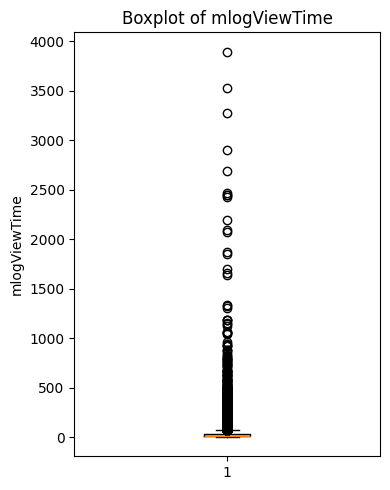

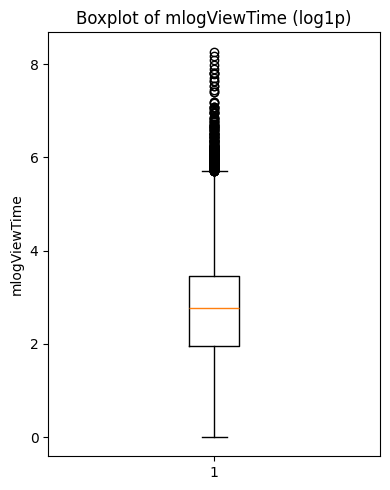

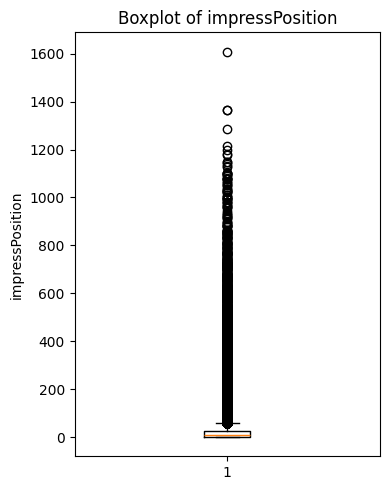

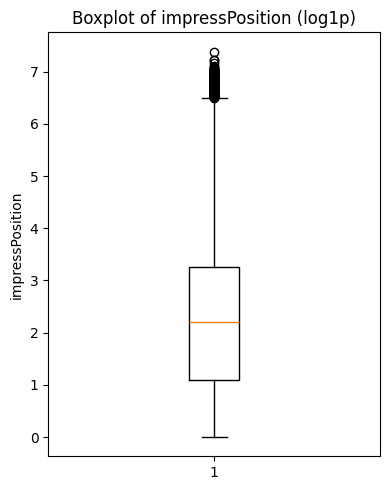

In [177]:

# Columns to plot
cols = ["followCnt", "publishTime", "mlogViewTime", "impressPosition"]

# Ensuring numeric types
df[cols] = df[cols].apply(pd.to_numeric, errors="coerce")

# Function to create a boxplot
def plot_box(col, log=False):
    s = df[col].dropna()
    plt.figure(figsize=(4, 5))
    data = np.log1p(s) if log else s
    plt.boxplot(data, showfliers=True)
    plt.title(f"Boxplot of {col}" + (" (log1p)" if log else ""))
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()

# boxplot 
for col in cols:
    if col in ["mlogViewTime", "impressPosition", "followCnt"]:
        plot_box(col, log=False)
        plot_box(col, log=True)
    else:
        plot_box(col)

#### Interpretation

- Follow Count: The raw distribution is heavily right-skewed, with a large number of users following very few accounts and a small number following hundreds. This causes the boxplot to compress near zero. After applying a logarithmic transformation (log1p(followCnt)), the distribution becomes more balanced and visually interpretable. 
- Publish Time: The variable displays a relatively symmetric distribution with few outliers, suggesting that most posts are published within a similar time frame. No transformation is needed.
- Mlog View Time: This variable exhibits extreme skewness, with a small portion of users spending very long viewing times compared to the majority. The log-transformed version (log1p(mlogViewTime)) effectively reduces the influence of these outliers, making it the preferred representation for modeling.
- Impress Position: Most impressions occur at lower positions (around 1–20), yet some values exceed 200, which could indicate exceptionally deep scrolls. The log transformation again produces a more interpretable spread. 

#### Transforming variables

In [178]:
#Normalize & coerce numerics
for col in ["mlogViewTime", "followCnt", "impressPosition", "registeredMonthCnt", "publishTime"]:
    if col in df.columns:
        df[col] = pd.to_numeric(to_na(df[col]), errors="coerce")

# Cap stable numerics
if "registeredMonthCnt" in df:
    cap_reg_month = df["registeredMonthCnt"].quantile(0.99)
    if pd.notna(cap_reg_month):
        df.loc[df["registeredMonthCnt"] > cap_reg_month, "registeredMonthCnt"] = cap_reg_month

if "publishTime" in df:
    cap_pub = df["publishTime"].quantile(0.995)
    if pd.notna(cap_pub):
        df.loc[df["publishTime"] > cap_pub, "publishTime"] = cap_pub

# mlogViewTime: fill + cap positives + log 
if "mlogViewTime" in df:
    vt = df["mlogViewTime"].fillna(0).clip(lower=0).astype("float64")
    pos = vt > 0
    q_hi = vt.loc[pos].quantile(0.99)
    if pd.notna(q_hi):
        vt.loc[pos & (vt > q_hi)] = float(q_hi)
    df["mlogViewTime_filled"] = vt
    df["mlogViewTime_log"] = np.log1p(vt)

# impressPosition: clean zeros, impute by day, then log 
if "impressPosition" in df:
    # treating 0 as invalid position (see Music Streaming paper)
    df.loc[df["impressPosition"] == 0, "impressPosition"] = np.nan
    df["impressPosition_missing"] = df["impressPosition"].isna().astype("uint8")
    imp_med_day = df.groupby("day", observed=True)["impressPosition"].transform("median") if "day" in df else np.nan
    imp_med_global = df["impressPosition"].median(skipna=True)
    df["impressPosition"] = df["impressPosition"].fillna(imp_med_day).fillna(imp_med_global)
    df["impressPosition_log"] = np.log1p(df["impressPosition"])

# followCnt log 
if "followCnt" in df:
    df["followCnt"] = pd.to_numeric(df["followCnt"], errors="coerce")
    df["followCnt_log"] = np.log1p(df["followCnt"].fillna(0).clip(lower=0))


# Checks
print({
    "mlogViewTime_log_na": float(df["mlogViewTime_log"].isna().mean()) if "mlogViewTime_log" in df else None,
    "impressPosition_log_na": float(df["impressPosition_log"].isna().mean()) if "impressPosition_log" in df else None,
    "followCnt_log_na": float(df["followCnt_log"].isna().mean()) if "followCnt_log" in df else None,
})
# Quick distribution check 
df[["followCnt", "followCnt_log", "mlogViewTime", "mlogViewTime_log", "impressPosition", "impressPosition_log"]].describe().T



{'mlogViewTime_log_na': 0.0, 'impressPosition_log_na': 0.0, 'followCnt_log_na': 0.0}


,count,mean,std,min,25%,50%,75%,max
followCnt,117349.0,5.261357,13.023062,0.000000,3.000000,3.000000,5.000000,1408.000000
followCnt_log,117349.0,1.602040,0.524735,0.000000,1.386294,1.386294,1.791759,7.250636
mlogViewTime,113450.0,23.656844,46.746001,0.000000,6.090000,14.770000,30.720000,3893.880000
mlogViewTime_log,117349.0,2.583288,1.117935,0.000000,1.868721,2.705380,3.434632,4.976757
impressPosition,117349.0,28.863207,67.856004,1.000000,2.000000,8.000000,25.000000,1609.000000
impressPosition_log,117349.0,2.353082,1.345639,0.693147,1.098612,2.197225,3.258097,7.383989


- Follow Count (followCnt): The raw variable had a wide range (0–1,408) with many extreme values. After applying a logarithmic transformation (log1p), the scale is compressed to 0–7.25, substantially reducing right skewness and making the variable more suitable for modeling.

- View Time (mlogViewTime): Previously dominated by a few very large viewing times (up to 2,895 seconds), the transformed version (mlogViewTime_log) now has a much smaller spread and a near-symmetric distribution. This ensures that long-tail observations no longer disproportionately influence the results.

- Impression Position (impressPosition): After applying a log transformation, the variable now ranges smoothly between 0.69 and 7.38. This retains interpretability while normalizing the scale.

### 6. Feature Engineering

This section constructs per-user features that capture behavioral intensity, diversity, and social interaction tendencies, using event-level data with action flags (`isClick`, `isLike`, `isShare`, etc.) and user metadata (`followCnt_log`, `creator_level`, etc.).

In [ ]:

# Ensure binary ints
acts = ['isClick','isComment','isIntoPersonalHomepage','isShare','isViewComment','isLike']
for c in acts:
    df[c] = df[c].astype(int)

# Recover follow count in levels and keep log for interactions
df['follow_cnt'] = np.exp(df['followCnt_log'])

# ----- Per-user aggregates -----
grp = df.groupby('userId', as_index=True)

# Basic counts
agg = grp.agg(
    total_impressions = ('mlogId', 'count'),
    clicks   = ('isClick', 'sum'),
    likes    = ('isLike', 'sum'),
    comments = ('isComment', 'sum'),
    shares   = ('isShare', 'sum'),
    homeviews= ('isIntoPersonalHomepage','sum'),
    viewcoms = ('isViewComment','sum'),
    mean_followCnt_log = ('followCnt_log','mean'),
    max_followCnt_log  = ('followCnt_log','max')
)

# Normalized rates and ratios (safe denominators)
den_imp = agg['total_impressions'].clip(lower=1)
agg['click_rate']   = agg['clicks']   / den_imp
agg['like_rate']    = agg['likes']    / den_imp
agg['comment_rate'] = agg['comments'] / den_imp
agg['share_rate']   = agg['shares']   / den_imp

agg['like_per_click']   = agg['likes']    / agg['clicks'].clip(lower=1)
agg['comment_per_view'] = agg['comments'] / den_imp
agg['share_per_view']   = agg['shares']   / den_imp

# Binary ever flags
agg['ever_clicked']   = (agg['clicks']   > 0).astype(int)
agg['ever_shared']    = (agg['shares']   > 0).astype(int)
agg['ever_commented'] = (agg['comments'] > 0).astype(int)

# Action diversity (how many action types >0)
action_sums = agg[['clicks','likes','comments','shares','homeviews','viewcoms']]
agg['action_types_taken'] = (action_sums > 0).sum(axis=1)

# Shannon entropy across action counts
counts = action_sums.to_numpy(dtype=float)
row_sums = counts.sum(axis=1, keepdims=True)
p = np.divide(counts, np.where(row_sums==0, 1, row_sums), where=(row_sums!=0))
entropy = -np.nansum(np.where(p>0, p*np.log(p), 0.0), axis=1)
entropy[row_sums.flatten()==0] = 0.0
agg['action_entropy'] = entropy

# Follow-weighted sharing (event-level -> user aggregates)
df['share_follow_evt'] = df['isShare'] * df['followCnt_log']
fw = df.groupby('userId')['share_follow_evt'].agg(['sum','max']).rename(
    columns={'sum':'sum_share_follow','max':'max_share_follow'}
)
agg = agg.join(fw, how='left').fillna({'sum_share_follow':0,'max_share_follow':0})

# Reach-propensity proxy
agg['shares_per_exp_follow_mean'] = agg['shares'] / np.exp(agg['mean_followCnt_log']).clip(lower=1)
agg['shares_per_exp_follow_max']  = agg['shares'] / np.exp(agg['max_followCnt_log']).clip(lower=1)


# Interaction terms
# Sum of per-event (isAction * followCnt_log)
for a in ['isLike','isShare','isComment']:
    name = f'sum_{a}_x_followlog'
    agg[name] = df.groupby('userId').apply(lambda g: (g[a] * g['followCnt_log']).sum())

# followCnt_log × action_rate
agg['action_rate'] = (agg['clicks'] + agg['likes'] + agg['comments'] + agg['shares']) / den_imp
agg['followlog_x_actionrate_mean'] = agg['mean_followCnt_log'] * agg['action_rate']

# Final NA clean
agg = agg.replace([np.inf, -np.inf], np.nan).fillna(0)

# Result: 
features_per_user = agg

/var/folders/dh/cy296tqx20qc0n7tcqw_n2lr0000gn/T/ipykernel_88916/2597380880.py:49: RuntimeWarning: divide by zero encountered in log
  entropy = -np.nansum(np.where(p>0, p*np.log(p), 0.0), axis=1)
/var/folders/dh/cy296tqx20qc0n7tcqw_n2lr0000gn/T/ipykernel_88916/2597380880.py:49: RuntimeWarning: invalid value encountered in multiply
  entropy = -np.nansum(np.where(p>0, p*np.log(p), 0.0), axis=1)
/var/folders/dh/cy296tqx20qc0n7tcqw_n2lr0000gn/T/ipykernel_88916/2597380880.py:69: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  agg[name] = df.groupby('userId').apply(lambda g: (g[a] * g['followCnt_log']).sum())
/var/folders/dh/cy296tqx20qc0n7tcqw_n2lr0000gn/T/ipykernel_88916/2597380880.py:69: FutureWarning: D

In [180]:
# Merge user-level features back to event-level data
df = df.merge(
    features_per_user.add_prefix("usr_"),  # prefix to avoid duplicate column names
    how="left",
    left_on="userId",
    right_index=True
)

print("Merged dataset shape:", df.shape)
print("Sample of new columns added:", [c for c in df.columns if c.startswith("usr_")][:30])



Merged dataset shape: (117349, 66)
Sample of new columns added: ['usr_total_impressions', 'usr_clicks', 'usr_likes', 'usr_comments', 'usr_shares', 'usr_homeviews', 'usr_viewcoms', 'usr_mean_followCnt_log', 'usr_max_followCnt_log', 'usr_click_rate', 'usr_like_rate', 'usr_comment_rate', 'usr_share_rate', 'usr_like_per_click', 'usr_comment_per_view', 'usr_share_per_view', 'usr_ever_clicked', 'usr_ever_shared', 'usr_ever_commented', 'usr_action_types_taken', 'usr_action_entropy', 'usr_sum_share_follow', 'usr_max_share_follow', 'usr_shares_per_exp_follow_mean', 'usr_shares_per_exp_follow_max', 'usr_sum_isLike_x_followlog', 'usr_sum_isShare_x_followlog', 'usr_sum_isComment_x_followlog', 'usr_action_rate', 'usr_followlog_x_actionrate_mean']


#### Normalized Action Rates and Ratios
Computed per `userId`:
- `click_rate` = clicks / total_impressions  
- `like_rate` = likes / total_impressions  
- `comment_rate` = comments / total_impressions  
- `share_rate` = shares / total_impressions  
- `like_per_click` = likes / max(clicks,1)  
- `comment_per_view` = comments / max(total_impressions,1)  
- `share_per_view` = shares / max(total_impressions,1)

#### Binary Ever Flags
Indicate whether the user has ever performed an action type:
- `ever_clicked` = 1 if clicks > 0  
- `ever_shared` = 1 if shares > 0  
- `ever_commented` = 1 if comments > 0

#### Action Diversity
- `action_types_taken` = number of distinct action types (among clicks, likes, comments, shares, homepage views, comment views) with sum > 0  
- `action_entropy` = Shannon entropy of normalized action counts  
  → higher values indicate more balanced engagement across action types

#### Follow-Weighted Sharing
Event-level feature: `share_follow_evt = isShare × followCnt_log`  
Then aggregated per user:
- `sum_share_follow` = Σ(share_follow_evt)  
- `max_share_follow` = max(share_follow_evt)

#### Reach-Propensity Proxy
Measures the user's sharing activity relative to their social reach:
- `shares_per_exp_follow_mean` = shares / exp(mean_followCnt_log)  
- `shares_per_exp_follow_max` = shares / exp(max_followCnt_log)

#### Interaction Terms with Social Reach
Cross-features capturing how actions change with the user’s follower count:
- `sum_isLike_x_followlog` = Σ(isLike × followCnt_log)  
- `sum_isShare_x_followlog` = Σ(isShare × followCnt_log)  
- `sum_isComment_x_followlog` = Σ(isComment × followCnt_log)  
- `followlog_x_actionrate_mean` = mean_followCnt_log × action_rate  
  where `action_rate` = (clicks + likes + comments + shares) ÷ total_impressions


### 7. Cleaning the dataset and saving

In [181]:
# Province normalization
df["province"] = (df["province"]
                  .astype(str).str.strip().str.lower().str.replace(r"\s+", " ", regex=True))

# Cast
for c in ["type","creatorType","user_level","creator_level"]:
    if c in df: df[c] = pd.to_numeric(df[c], errors="coerce").astype("Int64")

# Saving cleaned dataset for modeling
df_model = df.copy()

view_cols_to_drop = [
    "mlogViewTime",            # raw
    "followCnt",              # raw
    "follow_cnt",          # raw
    "impressPosition",       # raw
    "mlogViewTime_filled",     # helper variable (not further needed)
    "impressPosition_missing",  # helper variable (not further needed) 
    "rank_k",         # highly correlated with impressPosition
    "user_level",    # highly correlated with y_active
    "pop_index_pca_lag1",  # correlated with its lagged version
    "age_bin",         # derived variable
    'usr_total_impressions', 
    'usr_clicks', 
    'usr_likes', 
    'usr_comments',
    'usr_shares', 
    'usr_homeviews', 
    'usr_viewcoms', 
]
df_model = df_model.drop(columns=[c for c in view_cols_to_drop if c in df_model.columns])

#Dropping day to avoid multicollinearity with dt
df_model = df_model.drop(columns=["day"])


#### Saving the adjusted dataset

In [182]:
df_model.to_csv("../data/cleaned_data.csv", index=False)
# Final dataset shape
print("Cleaned dataset shape:", df_model.shape)
print(df_model.columns)


Cleaned dataset shape: (117349, 48)
Index(['dt', 'isClick', 'isComment', 'isIntoPersonalHomepage', 'isShare',
       'isViewComment', 'isLike', 'mlogId', 'userId', 'province', 'creatorId',
       'publishTime', 'type', 'contentId', 'talkId', 'creatorType',
       'creator_level', 'y_active', 'PushlishMlogCnt', 'age_gender_missing',
       'pop_index_pca', 'mlogViewTime_log', 'impressPosition_log',
       'followCnt_log', 'share_follow_evt', 'usr_mean_followCnt_log',
       'usr_max_followCnt_log', 'usr_click_rate', 'usr_like_rate',
       'usr_comment_rate', 'usr_share_rate', 'usr_like_per_click',
       'usr_comment_per_view', 'usr_share_per_view', 'usr_ever_clicked',
       'usr_ever_shared', 'usr_ever_commented', 'usr_action_types_taken',
       'usr_action_entropy', 'usr_sum_share_follow', 'usr_max_share_follow',
       'usr_shares_per_exp_follow_mean', 'usr_shares_per_exp_follow_max',
       'usr_sum_isLike_x_followlog', 'usr_sum_isShare_x_followlog',
       'usr_sum_isComment_x_f